In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp

print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras
print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os
import sys
import git
import importlib.util
from tqdm import trange

2.2.0
Listing all GPU resources:
[]

0.10.0


In [2]:
LAYER_NAME = 'linear_gaussian'
ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SAVE_PATH = "bayesian_model.h5"
N_DATA = 16
X_DIM = 2
EPOCHS = 1000
VERBOSE = 2
N_SAMPLES = 1000

PRIOR_MU = 0
PRIOR_STDDEV = 10
LIKELIHOOD_STDDEV = 0.1

np.random.seed(1)

In [3]:
X = np.random.rand(N_DATA, X_DIM)
y = (3*X[:, 0].reshape(-1, 1) 
     + 2*X[:, 1].reshape(-1, 1) 
     + np.random.normal(0, LIKELIHOOD_STDDEV, N_DATA).reshape(-1, 1))

print("-" * 30)
print("Loading training and testing data...")
print("-" * 30)

print('X:', X.shape)
print('y: ', y.shape)

Xy = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X),
                                tf.data.Dataset.from_tensor_slices(y))).cache()


------------------------------
Loading training and testing data...
------------------------------
X: (16, 2)
y:  (16, 1)


In [4]:
def make_model():

    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)
    
    likelihood_fn = tfp.distributions.MultivariateNormalDiag(np.zeros(N_DATA).astype(np.float32), 
                                                             scale_identity_multiplier=LIKELIHOOD_STDDEV)
    
    def gaussian_likelihood(y, y_pred):
        return -likelihood_fn.log_prob(y-y_pred)
    

    posterior_fn = tfp.layers.default_mean_field_normal_fn(
              loc_initializer=tf.random_normal_initializer(
                  mean=PRIOR_MU, stddev=0.05),
              untransformed_scale_initializer=tf.random_normal_initializer(
                  mean=np.log(np.exp(0.07) - 1), stddev=0.05))

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        dist = tfp.distributions.Normal(loc=PRIOR_MU*tf.ones(shape, dtype), 
                                 scale=PRIOR_STDDEV*tf.ones(shape, dtype))
        multivar_dist = tfp.distributions.Independent(dist, reinterpreted_batch_ndims=tf.size(dist.batch_shape_tensor()))

        return multivar_dist

    flipout_params = dict(kernel_prior_fn=prior_fn,
                          bias_prior_fn=prior_fn,
                          kernel_posterior_fn=posterior_fn,
                          bias_posterior_fn=posterior_fn,
                          kernel_divergence_fn=None,
                          bias_divergence_fn=None)

    input_layer = keras.layers.Input(shape=(X_DIM), name="input_layer")

    output_layer = tfp.layers.DenseFlipout(1, name='dense_layer', **flipout_params)(input_layer)
    
    print()
    print('Input size:', input_layer.shape)
    print('Output size:', output_layer.shape)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer,
                               name = 'model_' + LAYER_NAME)

    for layer in model.layers:
        if type(layer) == tfp.python.layers.dense_variational.DenseFlipout:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
            layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=2e-2),
                  loss=gaussian_likelihood,
                  metrics=[gaussian_likelihood],
                  )

    return model

In [5]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = make_model()

print('Model summary:')
print(model.summary())

print('Model losses:')
print(model.losses)

print("-" * 30)
print("Fitting model with training data ...")
print("-" * 30)

print("Training the model started at {}".format(datetime.datetime.now()))
start_time = time.time()

#Train the model
history = model.fit(Xy.batch(N_DATA).repeat(32).unbatch().batch(32*N_DATA),
                    epochs=EPOCHS, verbose=VERBOSE,
                    batch_size=N_DATA)

print("Total time elapsed for training = {} seconds".format(time.time() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))


# Save the model
# serialize weights to HDF5
model.save_weights(SAVE_PATH)

------------------------------
Constructing model...
------------------------------
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Instructions for updating:
Please use `layer.add_weight` method instead.

Input size: (None, 2)
Output size: (None, 1)
Model summary:
Model: "model_linear_gaussian"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_layer (DenseFlipout)   (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
Model losses:
[<tf.Tensor: shape=(), dtype=float32, numpy=9.029272>, <tf.Tensor: shape=(), dtype=float32, numpy=4.45907>]
------------------------------
Fitting model with training data ..

Epoch 92/1000
1/1 - 0s - gaussian_likelihood: 292.0229 - loss: 305.9329
Epoch 93/1000
1/1 - 0s - gaussian_likelihood: 300.7019 - loss: 314.6117
Epoch 94/1000
1/1 - 0s - gaussian_likelihood: 289.8465 - loss: 303.7566
Epoch 95/1000
1/1 - 0s - gaussian_likelihood: 283.2067 - loss: 297.1422
Epoch 96/1000
1/1 - 0s - gaussian_likelihood: 280.2908 - loss: 294.2267
Epoch 97/1000
1/1 - 0s - gaussian_likelihood: 277.4008 - loss: 291.3365
Epoch 98/1000
1/1 - 0s - gaussian_likelihood: 281.3820 - loss: 295.3184
Epoch 99/1000
1/1 - 0s - gaussian_likelihood: 278.3436 - loss: 292.2814
Epoch 100/1000
1/1 - 0s - gaussian_likelihood: 271.0159 - loss: 284.9607
Epoch 101/1000
1/1 - 0s - gaussian_likelihood: 274.4951 - loss: 288.4425
Epoch 102/1000
1/1 - 0s - gaussian_likelihood: 271.0384 - loss: 284.9854
Epoch 103/1000
1/1 - 0s - gaussian_likelihood: 268.8323 - loss: 282.7949
Epoch 104/1000
1/1 - 0s - gaussian_likelihood: 262.3511 - loss: 276.3158
Epoch 105/1000
1/1 - 0s - gaussian_likelihood: 258.7744 - l

Epoch 205/1000
1/1 - 0s - gaussian_likelihood: 126.0558 - loss: 140.1522
Epoch 206/1000
1/1 - 0s - gaussian_likelihood: 130.8417 - loss: 144.9381
Epoch 207/1000
1/1 - 0s - gaussian_likelihood: 123.0084 - loss: 137.1262
Epoch 208/1000
1/1 - 0s - gaussian_likelihood: 119.7277 - loss: 133.8547
Epoch 209/1000
1/1 - 0s - gaussian_likelihood: 145.8075 - loss: 159.9295
Epoch 210/1000
1/1 - 0s - gaussian_likelihood: 126.6178 - loss: 140.7410
Epoch 211/1000
1/1 - 0s - gaussian_likelihood: 122.7616 - loss: 136.9081
Epoch 212/1000
1/1 - 0s - gaussian_likelihood: 121.2264 - loss: 135.3876
Epoch 213/1000
1/1 - 0s - gaussian_likelihood: 116.0617 - loss: 130.2382
Epoch 214/1000
1/1 - 0s - gaussian_likelihood: 131.2104 - loss: 145.3889
Epoch 215/1000
1/1 - 0s - gaussian_likelihood: 110.0685 - loss: 124.2624
Epoch 216/1000
1/1 - 0s - gaussian_likelihood: 114.4523 - loss: 128.6497
Epoch 217/1000
1/1 - 0s - gaussian_likelihood: 114.0083 - loss: 128.2027
Epoch 218/1000
1/1 - 0s - gaussian_likelihood: 107.

Epoch 320/1000
1/1 - 0s - gaussian_likelihood: 38.6142 - loss: 52.9788
Epoch 321/1000
1/1 - 0s - gaussian_likelihood: 41.7977 - loss: 56.1553
Epoch 322/1000
1/1 - 0s - gaussian_likelihood: 32.9097 - loss: 47.2730
Epoch 323/1000
1/1 - 0s - gaussian_likelihood: 34.1810 - loss: 48.5407
Epoch 324/1000
1/1 - 0s - gaussian_likelihood: 32.3986 - loss: 46.7498
Epoch 325/1000
1/1 - 0s - gaussian_likelihood: 34.5761 - loss: 48.9212
Epoch 326/1000
1/1 - 0s - gaussian_likelihood: 31.8690 - loss: 46.2050
Epoch 327/1000
1/1 - 0s - gaussian_likelihood: 33.0108 - loss: 47.3434
Epoch 328/1000
1/1 - 0s - gaussian_likelihood: 30.4718 - loss: 44.8152
Epoch 329/1000
1/1 - 0s - gaussian_likelihood: 30.0013 - loss: 44.3394
Epoch 330/1000
1/1 - 0s - gaussian_likelihood: 28.6344 - loss: 42.9644
Epoch 331/1000
1/1 - 0s - gaussian_likelihood: 42.0445 - loss: 56.3648
Epoch 332/1000
1/1 - 0s - gaussian_likelihood: 32.4370 - loss: 46.7574
Epoch 333/1000
1/1 - 0s - gaussian_likelihood: 30.7003 - loss: 45.0174
Epoch 

Epoch 436/1000
1/1 - 0s - gaussian_likelihood: -2.1096e+00 - loss: 12.5182
Epoch 437/1000
1/1 - 0s - gaussian_likelihood: -5.4975e-01 - loss: 14.0743
Epoch 438/1000
1/1 - 0s - gaussian_likelihood: -3.6703e+00 - loss: 10.9472
Epoch 439/1000
1/1 - 0s - gaussian_likelihood: 0.6608 - loss: 15.2690
Epoch 440/1000
1/1 - 0s - gaussian_likelihood: -7.6002e-01 - loss: 13.8419
Epoch 441/1000
1/1 - 0s - gaussian_likelihood: -2.0135e-01 - loss: 14.3974
Epoch 442/1000
1/1 - 0s - gaussian_likelihood: 6.2306 - loss: 20.8290
Epoch 443/1000
1/1 - 0s - gaussian_likelihood: -3.6647e+00 - loss: 10.9417
Epoch 444/1000
1/1 - 0s - gaussian_likelihood: 0.3435 - loss: 14.9442
Epoch 445/1000
1/1 - 0s - gaussian_likelihood: -4.9181e-01 - loss: 14.1239
Epoch 446/1000
1/1 - 0s - gaussian_likelihood: -4.5219e+00 - loss: 10.1125
Epoch 447/1000
1/1 - 0s - gaussian_likelihood: -1.3457e+00 - loss: 13.2817
Epoch 448/1000
1/1 - 0s - gaussian_likelihood: -4.3304e+00 - loss: 10.3244
Epoch 449/1000
1/1 - 0s - gaussian_likel

Epoch 547/1000
1/1 - 0s - gaussian_likelihood: -1.1984e+01 - loss: 2.7347
Epoch 548/1000
1/1 - 0s - gaussian_likelihood: -3.9946e+00 - loss: 10.7247
Epoch 549/1000
1/1 - 0s - gaussian_likelihood: -1.2140e+01 - loss: 2.5752
Epoch 550/1000
1/1 - 0s - gaussian_likelihood: -1.4528e+01 - loss: 0.1987
Epoch 551/1000
1/1 - 0s - gaussian_likelihood: -1.3651e+01 - loss: 1.0661
Epoch 552/1000
1/1 - 0s - gaussian_likelihood: -1.0796e+01 - loss: 3.9216
Epoch 553/1000
1/1 - 0s - gaussian_likelihood: -1.4261e+01 - loss: 0.4563
Epoch 554/1000
1/1 - 0s - gaussian_likelihood: -1.2615e+01 - loss: 2.0958
Epoch 555/1000
1/1 - 0s - gaussian_likelihood: -9.7780e+00 - loss: 4.9404
Epoch 556/1000
1/1 - 0s - gaussian_likelihood: -9.8608e+00 - loss: 4.8686
Epoch 557/1000
1/1 - 0s - gaussian_likelihood: -7.4062e+00 - loss: 7.3207
Epoch 558/1000
1/1 - 0s - gaussian_likelihood: -1.3124e+01 - loss: 1.6129
Epoch 559/1000
1/1 - 0s - gaussian_likelihood: -9.1977e+00 - loss: 5.5449
Epoch 560/1000
1/1 - 0s - gaussian_li

Epoch 655/1000
1/1 - 0s - gaussian_likelihood: -1.3022e+01 - loss: 1.6591
Epoch 656/1000
1/1 - 0s - gaussian_likelihood: -1.6237e+01 - loss: -1.5499e+00
Epoch 657/1000
1/1 - 0s - gaussian_likelihood: -1.5221e+01 - loss: -5.3725e-01
Epoch 658/1000
1/1 - 0s - gaussian_likelihood: -1.4307e+01 - loss: 0.3679
Epoch 659/1000
1/1 - 0s - gaussian_likelihood: -1.4400e+01 - loss: 0.2645
Epoch 660/1000
1/1 - 0s - gaussian_likelihood: -1.3411e+01 - loss: 1.2716
Epoch 661/1000
1/1 - 0s - gaussian_likelihood: -1.5218e+01 - loss: -5.2964e-01
Epoch 662/1000
1/1 - 0s - gaussian_likelihood: -1.5597e+01 - loss: -8.9517e-01
Epoch 663/1000
1/1 - 0s - gaussian_likelihood: -1.5748e+01 - loss: -1.0484e+00
Epoch 664/1000
1/1 - 0s - gaussian_likelihood: -1.6395e+01 - loss: -1.7034e+00
Epoch 665/1000
1/1 - 0s - gaussian_likelihood: -1.3498e+01 - loss: 1.1908
Epoch 666/1000
1/1 - 0s - gaussian_likelihood: -1.6675e+01 - loss: -1.9585e+00
Epoch 667/1000
1/1 - 0s - gaussian_likelihood: -1.5344e+01 - loss: -6.3420e-0

Epoch 761/1000
1/1 - 0s - gaussian_likelihood: -1.5114e+01 - loss: -3.2149e-01
Epoch 762/1000
1/1 - 0s - gaussian_likelihood: -1.6129e+01 - loss: -1.3414e+00
Epoch 763/1000
1/1 - 0s - gaussian_likelihood: -1.7567e+01 - loss: -2.7778e+00
Epoch 764/1000
1/1 - 0s - gaussian_likelihood: -1.7593e+01 - loss: -2.8092e+00
Epoch 765/1000
1/1 - 0s - gaussian_likelihood: -1.7129e+01 - loss: -2.3536e+00
Epoch 766/1000
1/1 - 0s - gaussian_likelihood: -1.5776e+01 - loss: -1.0064e+00
Epoch 767/1000
1/1 - 0s - gaussian_likelihood: -1.7862e+01 - loss: -3.0918e+00
Epoch 768/1000
1/1 - 0s - gaussian_likelihood: -1.7568e+01 - loss: -2.8096e+00
Epoch 769/1000
1/1 - 0s - gaussian_likelihood: -1.5286e+01 - loss: -5.3694e-01
Epoch 770/1000
1/1 - 0s - gaussian_likelihood: -1.3802e+01 - loss: 0.9415
Epoch 771/1000
1/1 - 0s - gaussian_likelihood: -1.5223e+01 - loss: -4.6969e-01
Epoch 772/1000
1/1 - 0s - gaussian_likelihood: -1.4494e+01 - loss: 0.2511
Epoch 773/1000
1/1 - 0s - gaussian_likelihood: -1.5440e+01 - l

Epoch 866/1000
1/1 - 0s - gaussian_likelihood: -1.6164e+01 - loss: -1.3772e+00
Epoch 867/1000
1/1 - 0s - gaussian_likelihood: -1.5961e+01 - loss: -1.1800e+00
Epoch 868/1000
1/1 - 0s - gaussian_likelihood: -1.7594e+01 - loss: -2.8107e+00
Epoch 869/1000
1/1 - 0s - gaussian_likelihood: -1.7645e+01 - loss: -2.8688e+00
Epoch 870/1000
1/1 - 0s - gaussian_likelihood: -1.7437e+01 - loss: -2.6697e+00
Epoch 871/1000
1/1 - 0s - gaussian_likelihood: -1.6163e+01 - loss: -1.4012e+00
Epoch 872/1000
1/1 - 0s - gaussian_likelihood: -1.6812e+01 - loss: -2.0471e+00
Epoch 873/1000
1/1 - 0s - gaussian_likelihood: -1.3962e+01 - loss: 0.8037
Epoch 874/1000
1/1 - 0s - gaussian_likelihood: -1.6992e+01 - loss: -2.2104e+00
Epoch 875/1000
1/1 - 0s - gaussian_likelihood: -1.7987e+01 - loss: -3.2038e+00
Epoch 876/1000
1/1 - 0s - gaussian_likelihood: -1.7926e+01 - loss: -3.1526e+00
Epoch 877/1000
1/1 - 0s - gaussian_likelihood: -1.6658e+01 - loss: -1.8942e+00
Epoch 878/1000
1/1 - 0s - gaussian_likelihood: -8.8756e+0

Epoch 971/1000
1/1 - 0s - gaussian_likelihood: -1.8063e+01 - loss: -3.3843e+00
Epoch 972/1000
1/1 - 0s - gaussian_likelihood: -1.7007e+01 - loss: -2.3389e+00
Epoch 973/1000
1/1 - 0s - gaussian_likelihood: -1.7407e+01 - loss: -2.7444e+00
Epoch 974/1000
1/1 - 0s - gaussian_likelihood: -1.7764e+01 - loss: -3.1133e+00
Epoch 975/1000
1/1 - 0s - gaussian_likelihood: -1.6573e+01 - loss: -1.9334e+00
Epoch 976/1000
1/1 - 0s - gaussian_likelihood: -1.7057e+01 - loss: -2.4219e+00
Epoch 977/1000
1/1 - 0s - gaussian_likelihood: -1.5321e+01 - loss: -6.8874e-01
Epoch 978/1000
1/1 - 0s - gaussian_likelihood: -1.7779e+01 - loss: -3.1588e+00
Epoch 979/1000
1/1 - 0s - gaussian_likelihood: -1.3783e+01 - loss: 0.8234
Epoch 980/1000
1/1 - 0s - gaussian_likelihood: -1.4619e+01 - loss: 0.0266
Epoch 981/1000
1/1 - 0s - gaussian_likelihood: -1.3378e+01 - loss: 1.2802
Epoch 982/1000
1/1 - 0s - gaussian_likelihood: -1.1889e+01 - loss: 2.8128
Epoch 983/1000
1/1 - 0s - gaussian_likelihood: -1.6899e+01 - loss: -2.15

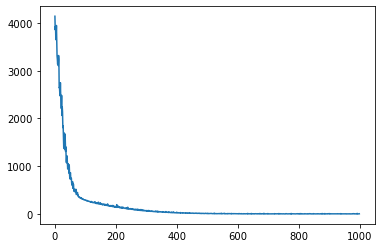

In [6]:
plt.plot(history.history['loss'])

In [7]:
for weights in model.get_weights():
    print('Weight/bias:', weights)

Weight/bias: [[2.9659534]
 [2.0497265]]
Weight/bias: [[-2.6076012]
 [-3.2030733]]
Weight/bias: [-0.02569823]
Weight/bias: [-3.431152]


In [8]:
y_predict = np.zeros((N_SAMPLES, N_DATA))
for i in trange(N_SAMPLES):
    y_predict[i] = model.predict(Xy.batch(N_DATA)).flatten()

100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]


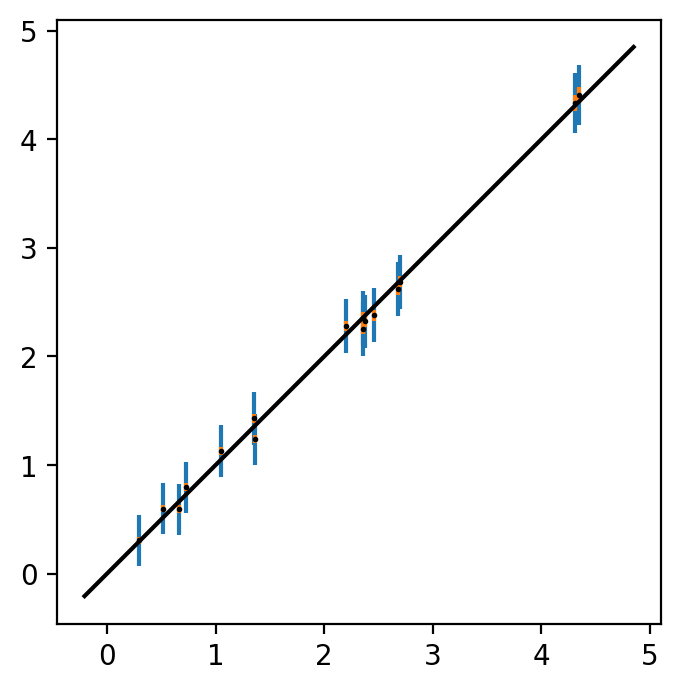

In [9]:
plt.figure(dpi=200)
plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0) + 2*LIKELIHOOD_STDDEV, 
             linestyle='None', marker=None)

plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0), 
             linestyle='None', marker='o', mec='k', ms=1)

plt.plot([y.min()-0.5, y.max()+0.5], [y.min()-0.5, y.max()+0.5], 'k')

plt.axis('square')


plt.show()

In [10]:
Xb = np.concatenate([X, np.ones((N_DATA, 1))], axis=1)
# Xb = X
Sigma_0 = PRIOR_STDDEV**2 * np.eye(Xb.shape[1])
Sigma_e = LIKELIHOOD_STDDEV**2 * np.eye(N_DATA)
Sigma_k = np.linalg.inv(np.linalg.inv(Sigma_0) + Xb.T @ Xb/LIKELIHOOD_STDDEV**2)
Mu_k = Sigma_k @ (Xb.T @ y/LIKELIHOOD_STDDEV**2)

In [11]:
Mu_k

array([[ 2.9611044 ],
       [ 2.06274995],
       [-0.03045692]])

In [12]:
print(model.get_weights()[0])
print(model.get_weights()[2])

[[2.9659534]
 [2.0497265]]
[-0.02569823]


In [13]:
Sigma_k

array([[ 1.67198019e-02, -8.95822761e-03,  6.29143709e-05],
       [-8.95822761e-03,  1.24619759e-02, -4.28791072e-03],
       [ 6.29143709e-05, -4.28791072e-03,  2.98722145e-03]])

In [14]:
U, s, V = np.linalg.svd(Sigma_k)
U @ np.diag(s**0.5) @ V
# np.linalg.cholesky(Sigma_k)


array([[ 0.12209459, -0.0418369 , -0.0078985 ],
       [-0.0418369 ,  0.09819937, -0.03268844],
       [-0.0078985 , -0.03268844,  0.04308481]])

In [15]:
print(np.log(np.exp(model.get_weights()[1]) + 1))
print(np.log(np.exp(model.get_weights()[3]) + 1))

[[0.07112102]
 [0.03983316]]
[0.03183747]
